In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import os
from tqdm.notebook import tqdm
from io import BytesIO
from PIL import Image
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
img_path = "data/train-00000-of-00001-a3cd901900de052e.parquet"
df = pd.read_parquet(img_path)
df.head()

,subCategory,image,text
0,Topwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,Men Navy Blue Shirt
1,Bottomwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,Men Party Blue Jeans
2,Watches,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,Women Silver Watch
3,Bottomwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,Men Solid Black Track Pants
4,Topwear,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,Men Grey T-shirt


In [3]:
dfLength = len(df)
dfLength

36145

In [4]:
# Function to convert bytes to images and preprocess for ResNet50
def preprocess_image_from_bytes(image_bytes):
    img = Image.open(BytesIO(image_bytes))
    img = img.resize((224, 224))
    img = img.convert('RGB')  # Ensure image is in RGB format
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess for ResNet
    return img_array

In [5]:
tqdm.pandas()

In [6]:
# Example of processing the first image
first_image_bytes = df.iloc[0]['image']['bytes']
first_image_processed = preprocess_image_from_bytes(first_image_bytes)
first_image_processed

array([[[[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        [[151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         ...,
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ],
         [151.061  , 138.22101, 131.32   ]],

        ...,

        [[142.061  , 138.22101, 131.32   ],
         [142.061  , 138.22101, 131.32   ],
         [142.061  , 138.22101, 131.32   ],
         ...,


In [7]:
text_descriptions = df['text'].values
text_descriptions

array(['Men Navy Blue Shirt', 'Men Party Blue Jeans',
       'Women Silver Watch', ..., "Men's Soccer Track Flip Flop",
       'Men Graphic Stellar Blue Tshirt',
       'Women Pink Dial Chronograph Watch ES3050'], dtype=object)

In [8]:
len(text_descriptions)

36145

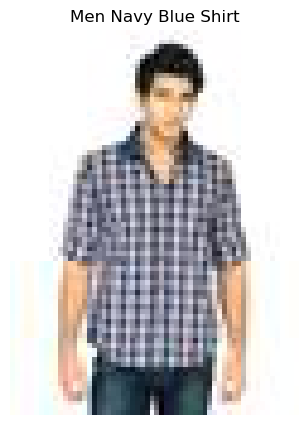

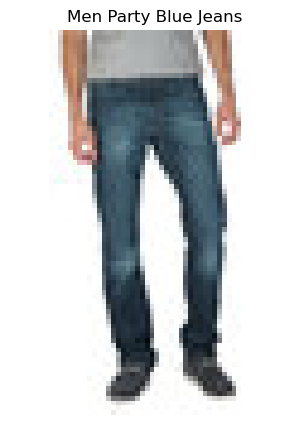

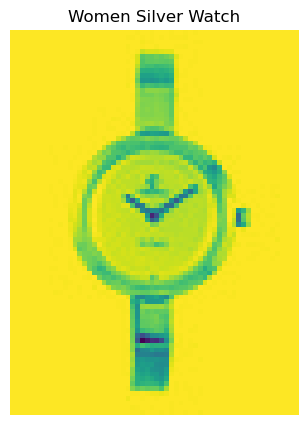

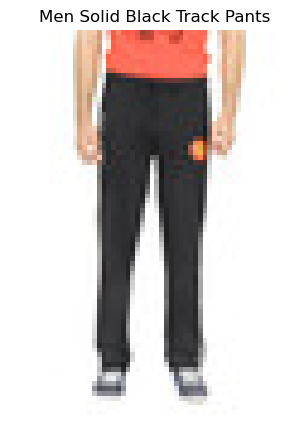

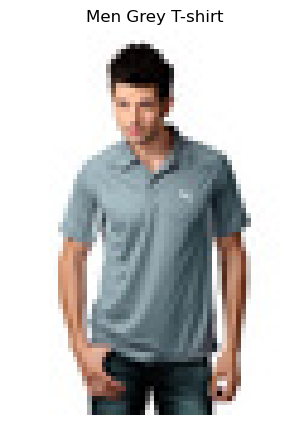

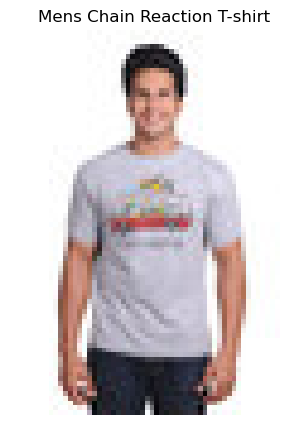

In [9]:

# Function to display images and captions
def display_images_with_captions(df, num_images=6):
    for _, row in df.head(num_images).iterrows():
        image_bytes = row['image']['bytes']
        img = Image.open(BytesIO(image_bytes))
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(row['text'])
        plt.axis('off')
        plt.show()

display_images_with_captions(df)


In [10]:
# Downloading the ResNet50 inception model

inception_model = ResNet50(include_top=True)
inception_model.summary()



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                     

 conv2_block2_add (Add)      (None, 56, 56, 256)          0         ['conv2_block1_out[0][0]',    
                                                                     'conv2_block2_3_bn[0][0]']   
                                                                                                  
 conv2_block2_out (Activati  (None, 56, 56, 256)          0         ['conv2_block2_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_2_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block2_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 rmalization)                                                                                     
                                                                                                  
 conv4_block1_1_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv4_block3_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block3_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block3_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block2_out[0][0]',    
                                                                     'conv4_block3_3_bn[0][0]']   
                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)       

                                                                                                  
 conv4_block6_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block6_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block6_3_conv (Conv2  (None, 14, 14, 1024)         263168    ['conv4_block6_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv5_block3_1_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
          

In [11]:
last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model 
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [12]:
# Extract features from images stored in DataFrame
img_features = {}
count = 0
for _, row in tqdm(df.iterrows(), total=df.shape[0]):
    # Read and preprocess the image
    image_bytes = row['image']['bytes']
    img = preprocess_image_from_bytes(image_bytes)
    
    # Get features from the model
    features = model.predict(img).reshape(2048,)
    
    # Store the features using the index or any other unique identifier
    img_features[row.name] = features
    
    # Update the count and print the status
    count += 1
    if count % 50 == 0:
        print(f'Processed {count} images')
    
    if count == 30000:
        break
        

  0%|          | 0/36145 [00:00<?, ?it/s]

1/1 [==============================] - 0s 107ms/step
Processed 50 images
1/1 [==============================] - 0s 97ms/step
Processed 100 images
1/1 [==============================] - 0s 93ms/step
Processed 150 images
1/1 [==============================] - 0s 94ms/step
Processed 200 images
1/1 [==============================] - 0s 97ms/step
Processed 250 images
1/1 [==============================] - 0s 92ms/step
Processed 300 images
1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 109ms/step
Processed 350 images
1/1 [==============================] - 0s 92ms/step
Processed 400 images
1/1 [==============================] - 0s 92ms/step
Processed 450 images
1/1 [==============================] - 0s 94ms/step
Processed 500 images
1/1 [==============================] - 0s 93ms/step
Processed 550 images
1/1 [==============================] - 0s 103ms/step
Processed 600 images
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 93ms/step
Processed 650 images
1/1 [==============================] - 0s 91ms/step
Processed 700 images
1/1 [==============================] - 0s 92ms/step
Processed 750 images
1/1 [==============================] - 0s 91ms/step
Processed 800 images
1/1 [==============================] - 0s 93ms/step
Processed 850 images
1/1 [==============================] - 0s 93ms/step
Processed 900 images
1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 103ms/step
Processed 950 images
1/1 [==============================] - 0s 97ms/step
Processed 1000 images
1/1 [==============================] - 0s 95ms/step
Processed 1050 images
1/1 [==============================] - 0s 95ms/step
Processed 1100 images
1/1 [==============================] - 0s 97ms/step
Processed 1150 images
1/1 [==============================] - 0s 96ms/step
Processed 1200 images
1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 94ms/step
Processed 1250 images
1/1 [==============================] - 0s 102ms/step
Processed 1300 images
1/1 [==============================] - 0s 107ms/step
Processed 1350 images
1/1 [==============================] - 0s 115ms/step
Processed 1400 images
1/1 [==============================] - 0s 98ms/step
Processed 1450 images
1/1 [==============================] - 0s 108ms/step
Processed 1500 images
1/1 [==============================] - 0s 104ms/step
Processed 1550 images
1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 98ms/step
Processed 1600 images
1/1 [==============================] - 0s 99ms/step
Processed 1650 images
1/1 [==============================] - 0s 105ms/step
Processed 1700 images
1/1 [==============================] - 0s 107ms/step
Processed 1750 images
1/1 [==============================] - 0s 114ms/step
Processed 1800 images
1/1 [==============================] - 0s 98ms/step
Processed 1850 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 103ms/step
Processed 1900 images
1/1 [==============================] - 0s 112ms/step
Processed 1950 images
1/1 [==============================] - 0s 107ms/step
Processed 2000 images
1/1 [==============================] - 0s 117ms/step
Processed 2050 images
1/1 [==============================] - 0s 104ms/step
Processed 2100 images
1/1 [==============================] - 0s 116ms/step
Processed 2150 images
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 101ms/step
Processed 2200 images
1/1 [==============================] - 0s 112ms/step
Processed 2250 images
1/1 [==============================] - 0s 103ms/step
Processed 2300 images
1/1 [==============================] - 0s 107ms/step
Processed 2350 images
1/1 [==============================] - 0s 102ms/step
Processed 2400 images
1/1 [==============================] - 0s 102ms/step
Processed 2450 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 105ms/step
Processed 2500 images
1/1 [==============================] - 0s 101ms/step
Processed 2550 images
1/1 [==============================] - 0s 115ms/step
Processed 2600 images
1/1 [==============================] - 0s 101ms/step
Processed 2650 images
1/1 [==============================] - 0s 108ms/step
Processed 2700 images
1/1 [==============================] - 0s 103ms/step
Processed 2750 images
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 112ms/step
Processed 2800 images
1/1 [==============================] - 0s 111ms/step
Processed 2850 images
1/1 [==============================] - 0s 122ms/step
Processed 2900 images
1/1 [==============================] - 0s 103ms/step
Processed 2950 images
1/1 [==============================] - 0s 116ms/step
Processed 3000 images
1/1 [==============================] - 0s 111ms/step
Processed 3050 images
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 102ms/step
Processed 3100 images
1/1 [==============================] - 0s 111ms/step
Processed 3150 images
1/1 [==============================] - 0s 125ms/step
Processed 3200 images
1/1 [==============================] - 0s 109ms/step
Processed 3250 images
1/1 [==============================] - 0s 122ms/step
Processed 3300 images
1/1 [==============================] - 0s 101ms/step
Processed 3350 images
1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 116ms/step
Processed 3400 images
1/1 [==============================] - 0s 106ms/step
Processed 3450 images
1/1 [==============================] - 0s 116ms/step
Processed 3500 images
1/1 [==============================] - 0s 103ms/step
Processed 3550 images
1/1 [==============================] - 0s 101ms/step
Processed 3600 images
1/1 [==============================] - 0s 100ms/step
Processed 3650 images
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 103ms/step
Processed 3700 images
1/1 [==============================] - 0s 111ms/step
Processed 3750 images
1/1 [==============================] - 0s 107ms/step
Processed 3800 images
1/1 [==============================] - 0s 110ms/step
Processed 3850 images


1/1 [==============================] - 0s 103ms/step
Processed 3900 images
1/1 [==============================] - 0s 102ms/step
Processed 3950 images
1/1 [==============================] - 0s 110ms/step
Processed 4000 images
1/1 [==============================] - 0s 117ms/step
Processed 4050 images
1/1 [==============================] - 0s 102ms/step
Processed 4100 images
1/1 [==============================] - 0s 110ms/step
Processed 4150 images
1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 100ms/step
Processed 4200 images
1/1 [==============================] - 0s 100ms/step
Processed 4250 images
1/1 [==============================] - 0s 109ms/step
Processed 4300 images
1/1 [==============================] - 0s 104ms/step
Processed 4350 images
1/1 [==============================] - 0s 107ms/step
Processed 4400 images
1/1 [==============================] - 0s 123ms/step
Processed 4450 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 122ms/step
Processed 4500 images
1/1 [==============================] - 0s 119ms/step
Processed 4550 images
1/1 [==============================] - 0s 102ms/step
Processed 4600 images
1/1 [==============================] - 0s 116ms/step
Processed 4650 images
1/1 [==============================] - 0s 101ms/step
Processed 4700 images
1/1 [==============================] - 0s 101ms/step
Processed 4750 images
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 109ms/step
Processed 4800 images
1/1 [==============================] - 0s 126ms/step
Processed 4850 images
1/1 [==============================] - 0s 108ms/step
Processed 4900 images
1/1 [==============================] - 0s 133ms/step
Processed 4950 images
1/1 [==============================] - 0s 102ms/step
Processed 5000 images
1/1 [==============================] - 0s 120ms/step
Processed 5050 images
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 106ms/step
Processed 5100 images
1/1 [==============================] - 0s 123ms/step
Processed 5150 images
1/1 [==============================] - 0s 108ms/step
Processed 5200 images
1/1 [==============================] - 0s 104ms/step
Processed 5250 images
1/1 [==============================] - 0s 108ms/step
Processed 5300 images
1/1 [==============================] - 0s 105ms/step
Processed 5350 images
1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 103ms/step
Processed 5400 images
1/1 [==============================] - 0s 123ms/step
Processed 5450 images
1/1 [==============================] - 0s 109ms/step
Processed 5500 images
1/1 [==============================] - 0s 119ms/step
Processed 5550 images
1/1 [==============================] - 0s 103ms/step
Processed 5600 images
1/1 [==============================] - 0s 120ms/step
Processed 5650 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 103ms/step
Processed 5700 images
1/1 [==============================] - 0s 119ms/step
Processed 5750 images
1/1 [==============================] - 0s 105ms/step
Processed 5800 images
1/1 [==============================] - 0s 121ms/step
Processed 5850 images
1/1 [==============================] - 0s 103ms/step
Processed 5900 images
1/1 [==============================] - 0s 119ms/step
Processed 5950 images
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 112ms/step
Processed 6000 images
1/1 [==============================] - 0s 128ms/step
Processed 6050 images
1/1 [==============================] - 0s 103ms/step
Processed 6100 images
1/1 [==============================] - 0s 113ms/step
Processed 6150 images
1/1 [==============================] - 0s 109ms/step
Processed 6200 images
1/1 [==============================] - 0s 124ms/step
Processed 6250 images
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 108ms/step
Processed 6300 images
1/1 [==============================] - 0s 120ms/step
Processed 6350 images
1/1 [==============================] - 0s 108ms/step
Processed 6400 images
1/1 [==============================] - 0s 121ms/step
Processed 6450 images
1/1 [==============================] - 0s 117ms/step


1/1 [==============================] - 0s 114ms/step
Processed 6500 images
1/1 [==============================] - 0s 128ms/step
Processed 6550 images
1/1 [==============================] - 0s 108ms/step
Processed 6600 images
1/1 [==============================] - 0s 121ms/step
Processed 6650 images
1/1 [==============================] - 0s 104ms/step
Processed 6700 images
1/1 [==============================] - 0s 123ms/step
Processed 6750 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 111ms/step
Processed 6800 images
1/1 [==============================] - 0s 124ms/step
Processed 6850 images
1/1 [==============================] - 0s 102ms/step
Processed 6900 images
1/1 [==============================] - 0s 122ms/step
Processed 6950 images
1/1 [==============================] - 0s 114ms/step
Processed 7000 images
1/1 [==============================] - 0s 117ms/step
Processed 7050 images
1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 106ms/step
Processed 7100 images
1/1 [==============================] - 0s 117ms/step
Processed 7150 images
1/1 [==============================] - 0s 105ms/step
Processed 7200 images
1/1 [==============================] - 0s 114ms/step
Processed 7250 images
1/1 [==============================] - 0s 104ms/step
Processed 7300 images
1/1 [==============================] - 0s 126ms/step
Processed 7350 images
1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 105ms/step
Processed 7400 images
1/1 [==============================] - 0s 132ms/step
Processed 7450 images
1/1 [==============================] - 0s 105ms/step
Processed 7500 images
1/1 [==============================] - 0s 125ms/step
Processed 7550 images
1/1 [==============================] - 0s 113ms/step
Processed 7600 images
1/1 [==============================] - 0s 127ms/step
Processed 7650 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 106ms/step
Processed 7700 images
1/1 [==============================] - 0s 107ms/step
Processed 7750 images
1/1 [==============================] - 0s 106ms/step
Processed 7800 images
1/1 [==============================] - 0s 105ms/step
Processed 7850 images
1/1 [==============================] - 0s 104ms/step
Processed 7900 images
1/1 [==============================] - 0s 118ms/step
Processed 7950 images
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 107ms/step
Processed 8000 images
1/1 [==============================] - 0s 123ms/step
Processed 8050 images
1/1 [==============================] - 0s 105ms/step
Processed 8100 images
1/1 [==============================] - 0s 128ms/step
Processed 8150 images
1/1 [==============================] - 0s 114ms/step
Processed 8200 images
1/1 [==============================] - 0s 125ms/step
Processed 8250 images
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 106ms/step
Processed 8300 images
1/1 [==============================] - 0s 115ms/step
Processed 8350 images
1/1 [==============================] - 0s 104ms/step
Processed 8400 images
1/1 [==============================] - 0s 123ms/step
Processed 8450 images
1/1 [==============================] - 0s 113ms/step
Processed 8500 images
1/1 [==============================] - 0s 125ms/step
Processed 8550 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 118ms/step
Processed 8600 images
1/1 [==============================] - 0s 107ms/step
Processed 8650 images
1/1 [==============================] - 0s 106ms/step
Processed 8700 images
1/1 [==============================] - 0s 114ms/step
Processed 8750 images
1/1 [==============================] - 0s 107ms/step
Processed 8800 images
1/1 [==============================] - 0s 107ms/step
Processed 8850 images
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 112ms/step
Processed 8900 images
1/1 [==============================] - 0s 112ms/step
Processed 8950 images
1/1 [==============================] - 0s 108ms/step
Processed 9000 images
1/1 [==============================] - 0s 113ms/step
Processed 9050 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 111ms/step
Processed 9100 images
1/1 [==============================] - 0s 111ms/step
Processed 9150 images
1/1 [==============================] - 0s 106ms/step
Processed 9200 images
1/1 [==============================] - 0s 111ms/step
Processed 9250 images
1/1 [==============================] - 0s 107ms/step
Processed 9300 images
1/1 [==============================] - 0s 111ms/step
Processed 9350 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 115ms/step
Processed 9400 images
1/1 [==============================] - 0s 107ms/step
Processed 9450 images
1/1 [==============================] - 0s 118ms/step
Processed 9500 images
1/1 [==============================] - 0s 119ms/step
Processed 9550 images
1/1 [==============================] - 0s 115ms/step
Processed 9600 images
1/1 [==============================] - 0s 113ms/step
Processed 9650 images
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 113ms/step
Processed 9700 images
1/1 [==============================] - 0s 108ms/step
Processed 9750 images
1/1 [==============================] - 0s 130ms/step
Processed 9800 images
1/1 [==============================] - 0s 108ms/step
Processed 9850 images
1/1 [==============================] - 0s 131ms/step
Processed 9900 images
1/1 [==============================] - 0s 106ms/step
Processed 9950 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 125ms/step
Processed 10000 images
1/1 [==============================] - 0s 106ms/step
Processed 10050 images
1/1 [==============================] - 0s 119ms/step
Processed 10100 images
1/1 [==============================] - 0s 112ms/step
Processed 10150 images
1/1 [==============================] - 0s 125ms/step
Processed 10200 images
1/1 [==============================] - 0s 113ms/step
Processed 10250 images
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 129ms/step
Processed 10300 images
1/1 [==============================] - 0s 116ms/step
Processed 10350 images
1/1 [==============================] - 0s 126ms/step
Processed 10400 images
1/1 [==============================] - 0s 117ms/step
Processed 10450 images
1/1 [==============================] - 0s 133ms/step
Processed 10500 images
1/1 [==============================] - 0s 112ms/step
Processed 10550 images
1/1 [==============================] - 0s 124ms/step


1/1 [==============================] - 0s 133ms/step
Processed 10600 images
1/1 [==============================] - 0s 105ms/step
Processed 10650 images
1/1 [==============================] - 0s 122ms/step
Processed 10700 images
1/1 [==============================] - 0s 112ms/step
Processed 10750 images
1/1 [==============================] - 0s 123ms/step
Processed 10800 images
1/1 [==============================] - 0s 109ms/step
Processed 10850 images
1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 122ms/step
Processed 10900 images
1/1 [==============================] - 0s 119ms/step
Processed 10950 images
1/1 [==============================] - 0s 126ms/step
Processed 11000 images
1/1 [==============================] - 0s 106ms/step
Processed 11050 images
1/1 [==============================] - 0s 114ms/step
Processed 11100 images
1/1 [==============================] - 0s 116ms/step
Processed 11150 images
1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 104ms/step
Processed 11200 images
1/1 [==============================] - 0s 106ms/step
Processed 11250 images
1/1 [==============================] - 0s 107ms/step
Processed 11300 images
1/1 [==============================] - 0s 107ms/step
Processed 11350 images
1/1 [==============================] - 0s 106ms/step
Processed 11400 images
1/1 [==============================] - 0s 104ms/step
Processed 11450 images
1/1 [==============================] - 0s 106ms/step
Processed 11500 images


1/1 [==============================] - 0s 104ms/step
Processed 11550 images
1/1 [==============================] - 0s 116ms/step
Processed 11600 images
1/1 [==============================] - 0s 108ms/step
Processed 11650 images
1/1 [==============================] - 0s 105ms/step
Processed 11700 images
1/1 [==============================] - 0s 106ms/step
Processed 11750 images
1/1 [==============================] - 0s 105ms/step
Processed 11800 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 114ms/step
Processed 11850 images
1/1 [==============================] - 0s 107ms/step
Processed 11900 images
1/1 [==============================] - 0s 104ms/step
Processed 11950 images
1/1 [==============================] - 0s 115ms/step
Processed 12000 images
1/1 [==============================] - 0s 103ms/step
Processed 12050 images
1/1 [==============================] - 0s 115ms/step
Processed 12100 images
1/1 [==============================] - 0s 103ms/step


1/1 [==============================] - 0s 120ms/step
Processed 12150 images
1/1 [==============================] - 0s 105ms/step
Processed 12200 images
1/1 [==============================] - 0s 109ms/step
Processed 12250 images
1/1 [==============================] - 0s 114ms/step
Processed 12300 images
1/1 [==============================] - 0s 111ms/step
Processed 12350 images
1/1 [==============================] - 0s 107ms/step
Processed 12400 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 104ms/step
Processed 12450 images
1/1 [==============================] - 0s 106ms/step
Processed 12500 images
1/1 [==============================] - 0s 105ms/step
Processed 12550 images
1/1 [==============================] - 0s 106ms/step
Processed 12600 images
1/1 [==============================] - 0s 105ms/step
Processed 12650 images
1/1 [==============================] - 0s 107ms/step
Processed 12700 images
1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 115ms/step
Processed 12750 images
1/1 [==============================] - 0s 104ms/step
Processed 12800 images
1/1 [==============================] - 0s 129ms/step
Processed 12850 images
1/1 [==============================] - 0s 122ms/step
Processed 12900 images
1/1 [==============================] - 0s 126ms/step
Processed 12950 images
1/1 [==============================] - 0s 106ms/step
Processed 13000 images
1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 125ms/step
Processed 13050 images
1/1 [==============================] - 0s 105ms/step
Processed 13100 images
1/1 [==============================] - 0s 128ms/step
Processed 13150 images
1/1 [==============================] - 0s 116ms/step
Processed 13200 images
1/1 [==============================] - 0s 125ms/step
Processed 13250 images
1/1 [==============================] - 0s 104ms/step
Processed 13300 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 131ms/step
Processed 13350 images
1/1 [==============================] - 0s 111ms/step
Processed 13400 images
1/1 [==============================] - 0s 117ms/step
Processed 13450 images
1/1 [==============================] - 0s 109ms/step
Processed 13500 images
1/1 [==============================] - 0s 115ms/step
Processed 13550 images
1/1 [==============================] - 0s 106ms/step
Processed 13600 images
1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 109ms/step
Processed 13650 images
1/1 [==============================] - 0s 108ms/step
Processed 13700 images
1/1 [==============================] - 0s 122ms/step
Processed 13750 images
1/1 [==============================] - 0s 106ms/step
Processed 13800 images
1/1 [==============================] - 0s 138ms/step
Processed 13850 images
1/1 [==============================] - 0s 112ms/step
Processed 13900 images
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 119ms/step
Processed 13950 images
1/1 [==============================] - 0s 103ms/step
Processed 14000 images
1/1 [==============================] - 0s 115ms/step
Processed 14050 images
1/1 [==============================] - 0s 114ms/step
Processed 14100 images
1/1 [==============================] - 0s 106ms/step
Processed 14150 images
1/1 [==============================] - 0s 106ms/step
Processed 14200 images
1/1 [==============================] - 0s 110ms/step
Processed 14250 images
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 106ms/step
Processed 14300 images
1/1 [==============================] - 0s 113ms/step
Processed 14350 images
1/1 [==============================] - 0s 112ms/step
Processed 14400 images
1/1 [==============================] - 0s 113ms/step
Processed 14450 images
1/1 [==============================] - 0s 107ms/step
Processed 14500 images
1/1 [==============================] - 0s 106ms/step
Processed 14550 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 107ms/step
Processed 14600 images
1/1 [==============================] - 0s 107ms/step
Processed 14650 images
1/1 [==============================] - 0s 106ms/step
Processed 14700 images
1/1 [==============================] - 0s 116ms/step
Processed 14750 images
1/1 [==============================] - 0s 107ms/step
Processed 14800 images
1/1 [==============================] - 0s 104ms/step
Processed 14850 images
1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 114ms/step
Processed 14900 images
1/1 [==============================] - 0s 111ms/step
Processed 14950 images
1/1 [==============================] - 0s 105ms/step
Processed 15000 images
1/1 [==============================] - 0s 117ms/step
Processed 15050 images
1/1 [==============================] - 0s 113ms/step
Processed 15100 images
1/1 [==============================] - 0s 112ms/step
Processed 15150 images
1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 109ms/step
Processed 15200 images
1/1 [==============================] - 0s 108ms/step
Processed 15250 images
1/1 [==============================] - 0s 122ms/step
Processed 15300 images
1/1 [==============================] - 0s 108ms/step
Processed 15350 images
1/1 [==============================] - 0s 122ms/step
Processed 15400 images
1/1 [==============================] - 0s 115ms/step
Processed 15450 images
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 126ms/step
Processed 15500 images
1/1 [==============================] - 0s 105ms/step
Processed 15550 images
1/1 [==============================] - 0s 121ms/step
Processed 15600 images
1/1 [==============================] - 0s 109ms/step
Processed 15650 images
1/1 [==============================] - 0s 121ms/step
Processed 15700 images
1/1 [==============================] - 0s 112ms/step
Processed 15750 images
1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 123ms/step
Processed 15800 images
1/1 [==============================] - 0s 112ms/step
Processed 15850 images
1/1 [==============================] - 0s 127ms/step
Processed 15900 images
1/1 [==============================] - 0s 115ms/step
Processed 15950 images
1/1 [==============================] - 0s 121ms/step
Processed 16000 images
1/1 [==============================] - 0s 121ms/step
Processed 16050 images
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 118ms/step
Processed 16100 images
1/1 [==============================] - 0s 117ms/step
Processed 16150 images
1/1 [==============================] - 0s 126ms/step
Processed 16200 images
1/1 [==============================] - 0s 112ms/step
Processed 16250 images
1/1 [==============================] - 0s 138ms/step
Processed 16300 images
1/1 [==============================] - 0s 111ms/step
Processed 16350 images
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 117ms/step
Processed 16400 images
1/1 [==============================] - 0s 105ms/step
Processed 16450 images
1/1 [==============================] - 0s 108ms/step
Processed 16500 images
1/1 [==============================] - 0s 117ms/step
Processed 16550 images
1/1 [==============================] - 0s 106ms/step
Processed 16600 images
1/1 [==============================] - 0s 108ms/step
Processed 16650 images
1/1 [==============================] - 0s 114ms/step
Processed 16700 images


1/1 [==============================] - 0s 115ms/step
Processed 16750 images
1/1 [==============================] - 0s 108ms/step
Processed 16800 images
1/1 [==============================] - 0s 109ms/step
Processed 16850 images
1/1 [==============================] - 0s 115ms/step
Processed 16900 images
1/1 [==============================] - 0s 116ms/step
Processed 16950 images
1/1 [==============================] - 0s 107ms/step
Processed 17000 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 114ms/step
Processed 17050 images
1/1 [==============================] - 0s 107ms/step
Processed 17100 images
1/1 [==============================] - 0s 107ms/step
Processed 17150 images
1/1 [==============================] - 0s 111ms/step
Processed 17200 images
1/1 [==============================] - 0s 108ms/step
Processed 17250 images
1/1 [==============================] - 0s 104ms/step
Processed 17300 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 116ms/step
Processed 17350 images
1/1 [==============================] - 0s 111ms/step
Processed 17400 images
1/1 [==============================] - 0s 113ms/step
Processed 17450 images
1/1 [==============================] - 0s 116ms/step
Processed 17500 images
1/1 [==============================] - 0s 124ms/step
Processed 17550 images
1/1 [==============================] - 0s 115ms/step
Processed 17600 images
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 116ms/step
Processed 17650 images
1/1 [==============================] - 0s 109ms/step
Processed 17700 images
1/1 [==============================] - 0s 122ms/step
Processed 17750 images
1/1 [==============================] - 0s 110ms/step
Processed 17800 images
1/1 [==============================] - 0s 127ms/step
Processed 17850 images
1/1 [==============================] - 0s 110ms/step
Processed 17900 images
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 128ms/step
Processed 17950 images
1/1 [==============================] - 0s 106ms/step
Processed 18000 images
1/1 [==============================] - 0s 122ms/step
Processed 18050 images
1/1 [==============================] - 0s 111ms/step
Processed 18100 images
1/1 [==============================] - 0s 113ms/step
Processed 18150 images
1/1 [==============================] - 0s 117ms/step
Processed 18200 images
1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 123ms/step
Processed 18250 images
1/1 [==============================] - 0s 113ms/step
Processed 18300 images
1/1 [==============================] - 0s 114ms/step
Processed 18350 images
1/1 [==============================] - 0s 106ms/step
Processed 18400 images
1/1 [==============================] - 0s 114ms/step
Processed 18450 images
1/1 [==============================] - 0s 111ms/step
Processed 18500 images
1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 107ms/step
Processed 18550 images
1/1 [==============================] - 0s 122ms/step
Processed 18600 images
1/1 [==============================] - 0s 107ms/step
Processed 18650 images
1/1 [==============================] - 0s 108ms/step
Processed 18700 images
1/1 [==============================] - 0s 112ms/step
Processed 18750 images
1/1 [==============================] - 0s 125ms/step
Processed 18800 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 115ms/step
Processed 18850 images
1/1 [==============================] - 0s 117ms/step
Processed 18900 images
1/1 [==============================] - 0s 121ms/step
Processed 18950 images
1/1 [==============================] - 0s 110ms/step
Processed 19000 images
1/1 [==============================] - 0s 114ms/step
Processed 19050 images
1/1 [==============================] - 0s 130ms/step
Processed 19100 images
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 107ms/step
Processed 19150 images
1/1 [==============================] - 0s 116ms/step
Processed 19200 images
1/1 [==============================] - 0s 115ms/step
Processed 19250 images
1/1 [==============================] - 0s 106ms/step
Processed 19300 images
1/1 [==============================] - 0s 106ms/step
Processed 19350 images
1/1 [==============================] - 0s 127ms/step
Processed 19400 images
1/1 [==============================] - 0s 110ms/step
Processed 19450 images
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 123ms/step
Processed 19500 images
1/1 [==============================] - 0s 108ms/step
Processed 19550 images
1/1 [==============================] - 0s 123ms/step
Processed 19600 images
1/1 [==============================] - 0s 108ms/step
Processed 19650 images
1/1 [==============================] - 0s 127ms/step
Processed 19700 images
1/1 [==============================] - 0s 108ms/step
Processed 19750 images
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 108ms/step
Processed 19800 images
1/1 [==============================] - 0s 126ms/step
Processed 19850 images
1/1 [==============================] - 0s 127ms/step
Processed 19900 images
1/1 [==============================] - 0s 107ms/step
Processed 19950 images
1/1 [==============================] - 0s 130ms/step
Processed 20000 images
1/1 [==============================] - 0s 105ms/step
Processed 20050 images
1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 123ms/step
Processed 20100 images
1/1 [==============================] - 0s 118ms/step
Processed 20150 images
1/1 [==============================] - 0s 117ms/step
Processed 20200 images
1/1 [==============================] - 0s 117ms/step
Processed 20250 images
1/1 [==============================] - 0s 107ms/step
Processed 20300 images
1/1 [==============================] - 0s 105ms/step
Processed 20350 images
1/1 [==============================] - 0s 122ms/step


1/1 [==============================] - 0s 117ms/step
Processed 20400 images
1/1 [==============================] - 0s 115ms/step
Processed 20450 images
1/1 [==============================] - 0s 106ms/step
Processed 20500 images
1/1 [==============================] - 0s 113ms/step
Processed 20550 images
1/1 [==============================] - 0s 110ms/step
Processed 20600 images
1/1 [==============================] - 0s 110ms/step
Processed 20650 images
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 108ms/step
Processed 20700 images
1/1 [==============================] - 0s 111ms/step
Processed 20750 images
1/1 [==============================] - 0s 119ms/step
Processed 20800 images
1/1 [==============================] - 0s 114ms/step
Processed 20850 images
1/1 [==============================] - 0s 108ms/step
Processed 20900 images
1/1 [==============================] - 0s 116ms/step
Processed 20950 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 114ms/step
Processed 21000 images
1/1 [==============================] - 0s 133ms/step
Processed 21050 images
1/1 [==============================] - 0s 106ms/step
Processed 21100 images
1/1 [==============================] - 0s 126ms/step
Processed 21150 images
1/1 [==============================] - 0s 106ms/step
Processed 21200 images
1/1 [==============================] - 0s 131ms/step
Processed 21250 images
1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 115ms/step
Processed 21300 images
1/1 [==============================] - 0s 126ms/step
Processed 21350 images
1/1 [==============================] - 0s 105ms/step
Processed 21400 images
1/1 [==============================] - 0s 125ms/step
Processed 21450 images
1/1 [==============================] - 0s 108ms/step
Processed 21500 images
1/1 [==============================] - 0s 129ms/step
Processed 21550 images
1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 110ms/step
Processed 21600 images
1/1 [==============================] - 0s 107ms/step
Processed 21650 images
1/1 [==============================] - 0s 120ms/step
Processed 21700 images
1/1 [==============================] - 0s 106ms/step
Processed 21750 images
1/1 [==============================] - 0s 115ms/step
Processed 21800 images
1/1 [==============================] - 0s 115ms/step
Processed 21850 images
1/1 [==============================] - 0s 117ms/step
Processed 21900 images


1/1 [==============================] - 0s 107ms/step
Processed 21950 images
1/1 [==============================] - 0s 116ms/step
Processed 22000 images
1/1 [==============================] - 0s 106ms/step
Processed 22050 images
1/1 [==============================] - 0s 106ms/step
Processed 22100 images
1/1 [==============================] - 0s 107ms/step
Processed 22150 images
1/1 [==============================] - 0s 116ms/step
Processed 22200 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 106ms/step
Processed 22250 images
1/1 [==============================] - 0s 109ms/step
Processed 22300 images
1/1 [==============================] - 0s 115ms/step
Processed 22350 images
1/1 [==============================] - 0s 110ms/step
Processed 22400 images
1/1 [==============================] - 0s 112ms/step
Processed 22450 images
1/1 [==============================] - 0s 127ms/step
Processed 22500 images
1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 118ms/step
Processed 22550 images
1/1 [==============================] - 0s 126ms/step
Processed 22600 images
1/1 [==============================] - 0s 111ms/step
Processed 22650 images
1/1 [==============================] - 0s 118ms/step
Processed 22700 images
1/1 [==============================] - 0s 116ms/step
Processed 22750 images
1/1 [==============================] - 0s 121ms/step
Processed 22800 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 116ms/step
Processed 22850 images
1/1 [==============================] - 0s 124ms/step
Processed 22900 images
1/1 [==============================] - 0s 109ms/step
Processed 22950 images
1/1 [==============================] - 0s 127ms/step
Processed 23000 images
1/1 [==============================] - 0s 107ms/step
Processed 23050 images
1/1 [==============================] - 0s 138ms/step
Processed 23100 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 113ms/step
Processed 23150 images
1/1 [==============================] - 0s 124ms/step
Processed 23200 images
1/1 [==============================] - 0s 115ms/step
Processed 23250 images
1/1 [==============================] - 0s 108ms/step
Processed 23300 images
1/1 [==============================] - 0s 116ms/step
Processed 23350 images
1/1 [==============================] - 0s 105ms/step
Processed 23400 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 103ms/step
Processed 23450 images
1/1 [==============================] - 0s 106ms/step
Processed 23500 images
1/1 [==============================] - 0s 115ms/step
Processed 23550 images
1/1 [==============================] - 0s 115ms/step
Processed 23600 images
1/1 [==============================] - 0s 114ms/step
Processed 23650 images
1/1 [==============================] - 0s 107ms/step
Processed 23700 images
1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 105ms/step
Processed 23750 images
1/1 [==============================] - 0s 105ms/step
Processed 23800 images
1/1 [==============================] - 0s 116ms/step
Processed 23850 images
1/1 [==============================] - 0s 115ms/step
Processed 23900 images
1/1 [==============================] - 0s 134ms/step
Processed 23950 images
1/1 [==============================] - 0s 105ms/step
Processed 24000 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 121ms/step
Processed 24050 images
1/1 [==============================] - 0s 107ms/step
Processed 24100 images
1/1 [==============================] - 0s 129ms/step
Processed 24150 images
1/1 [==============================] - 0s 117ms/step
Processed 24200 images
1/1 [==============================] - 0s 127ms/step
Processed 24250 images
1/1 [==============================] - 0s 115ms/step
Processed 24300 images
1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 125ms/step
Processed 24350 images
1/1 [==============================] - 0s 105ms/step
Processed 24400 images
1/1 [==============================] - 0s 121ms/step
Processed 24450 images
1/1 [==============================] - 0s 117ms/step
Processed 24500 images
1/1 [==============================] - 0s 126ms/step
Processed 24550 images
1/1 [==============================] - 0s 107ms/step
Processed 24600 images
1/1 [==============================] - 0s 135ms/step
Processed 24650 images
1/1 [==============================] - 0s 123ms/step


1/1 [==============================] - 0s 117ms/step
Processed 24700 images
1/1 [==============================] - 0s 105ms/step
Processed 24750 images
1/1 [==============================] - 0s 105ms/step
Processed 24800 images
1/1 [==============================] - 0s 116ms/step
Processed 24850 images
1/1 [==============================] - 0s 110ms/step
Processed 24900 images
1/1 [==============================] - 0s 117ms/step
Processed 24950 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 117ms/step
Processed 25000 images
1/1 [==============================] - 0s 107ms/step
Processed 25050 images
1/1 [==============================] - 0s 107ms/step
Processed 25100 images
1/1 [==============================] - 0s 108ms/step
Processed 25150 images
1/1 [==============================] - 0s 107ms/step
Processed 25200 images
1/1 [==============================] - 0s 109ms/step
Processed 25250 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 107ms/step
Processed 25300 images
1/1 [==============================] - 0s 108ms/step
Processed 25350 images
1/1 [==============================] - 0s 116ms/step
Processed 25400 images
1/1 [==============================] - 0s 105ms/step
Processed 25450 images
1/1 [==============================] - 0s 116ms/step
Processed 25500 images
1/1 [==============================] - 0s 113ms/step
Processed 25550 images
1/1 [==============================] - 0s 107ms/step


1/1 [==============================] - 0s 128ms/step
Processed 25600 images
1/1 [==============================] - 0s 114ms/step
Processed 25650 images
1/1 [==============================] - 0s 130ms/step
Processed 25700 images
1/1 [==============================] - 0s 109ms/step
Processed 25750 images
1/1 [==============================] - 0s 127ms/step
Processed 25800 images
1/1 [==============================] - 0s 108ms/step
Processed 25850 images
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 125ms/step
Processed 25900 images
1/1 [==============================] - 0s 118ms/step
Processed 25950 images
1/1 [==============================] - 0s 116ms/step
Processed 26000 images
1/1 [==============================] - 0s 107ms/step
Processed 26050 images
1/1 [==============================] - 0s 124ms/step
Processed 26100 images
1/1 [==============================] - 0s 107ms/step
Processed 26150 images
1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 126ms/step
Processed 26200 images
1/1 [==============================] - 0s 107ms/step
Processed 26250 images
1/1 [==============================] - 0s 106ms/step
Processed 26300 images
1/1 [==============================] - 0s 108ms/step
Processed 26350 images
1/1 [==============================] - 0s 113ms/step
Processed 26400 images
1/1 [==============================] - 0s 110ms/step
Processed 26450 images
1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 115ms/step
Processed 26500 images
1/1 [==============================] - 0s 134ms/step
Processed 26550 images
1/1 [==============================] - 0s 115ms/step
Processed 26600 images
1/1 [==============================] - 0s 125ms/step
Processed 26650 images
1/1 [==============================] - 0s 112ms/step
Processed 26700 images
1/1 [==============================] - 0s 112ms/step
Processed 26750 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 125ms/step
Processed 26800 images
1/1 [==============================] - 0s 110ms/step
Processed 26850 images
1/1 [==============================] - 0s 119ms/step
Processed 26900 images
1/1 [==============================] - 0s 119ms/step
Processed 26950 images
1/1 [==============================] - 0s 113ms/step
Processed 27000 images
1/1 [==============================] - 0s 106ms/step
Processed 27050 images
1/1 [==============================] - 0s 113ms/step
Processed 27100 images


1/1 [==============================] - 0s 137ms/step
Processed 27150 images
1/1 [==============================] - 0s 120ms/step
Processed 27200 images
1/1 [==============================] - 0s 110ms/step
Processed 27250 images
1/1 [==============================] - 0s 124ms/step
Processed 27300 images
1/1 [==============================] - 0s 122ms/step
Processed 27350 images
1/1 [==============================] - 0s 117ms/step
Processed 27400 images
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 107ms/step
Processed 27450 images
1/1 [==============================] - 0s 110ms/step
Processed 27500 images
1/1 [==============================] - 0s 110ms/step
Processed 27550 images
1/1 [==============================] - 0s 131ms/step
Processed 27600 images
1/1 [==============================] - 0s 138ms/step
Processed 27650 images
1/1 [==============================] - 0s 108ms/step
Processed 27700 images
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 135ms/step
Processed 27750 images
1/1 [==============================] - 0s 108ms/step
Processed 27800 images
1/1 [==============================] - 0s 120ms/step
Processed 27850 images
1/1 [==============================] - 0s 106ms/step
Processed 27900 images
1/1 [==============================] - 0s 124ms/step
Processed 27950 images
1/1 [==============================] - 0s 106ms/step
Processed 28000 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 115ms/step
Processed 28050 images
1/1 [==============================] - 0s 107ms/step
Processed 28100 images
1/1 [==============================] - 0s 107ms/step
Processed 28150 images
1/1 [==============================] - 0s 110ms/step
Processed 28200 images
1/1 [==============================] - 0s 108ms/step
Processed 28250 images
1/1 [==============================] - 0s 105ms/step
Processed 28300 images
1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 130ms/step
Processed 28350 images
1/1 [==============================] - 0s 108ms/step
Processed 28400 images
1/1 [==============================] - 0s 109ms/step
Processed 28450 images
1/1 [==============================] - 0s 108ms/step
Processed 28500 images
1/1 [==============================] - 0s 108ms/step
Processed 28550 images
1/1 [==============================] - 0s 116ms/step
Processed 28600 images
1/1 [==============================] - 0s 119ms/step


1/1 [==============================] - 0s 114ms/step
Processed 28650 images
1/1 [==============================] - 0s 115ms/step
Processed 28700 images
1/1 [==============================] - 0s 108ms/step
Processed 28750 images
1/1 [==============================] - 0s 114ms/step
Processed 28800 images
1/1 [==============================] - 0s 108ms/step
Processed 28850 images
1/1 [==============================] - 0s 131ms/step
Processed 28900 images
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 118ms/step
Processed 28950 images
1/1 [==============================] - 0s 138ms/step
Processed 29000 images
1/1 [==============================] - 0s 116ms/step
Processed 29050 images
1/1 [==============================] - 0s 127ms/step
Processed 29100 images
1/1 [==============================] - 0s 113ms/step
Processed 29150 images
1/1 [==============================] - 0s 148ms/step
Processed 29200 images
1/1 [==============================] - 0s 108ms/step


1/1 [==============================] - 0s 114ms/step
Processed 29250 images
1/1 [==============================] - 0s 121ms/step
Processed 29300 images
1/1 [==============================] - 0s 110ms/step
Processed 29350 images
1/1 [==============================] - 0s 139ms/step
Processed 29400 images
1/1 [==============================] - 0s 116ms/step
Processed 29450 images
1/1 [==============================] - 0s 116ms/step
Processed 29500 images
1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 111ms/step
Processed 29550 images
1/1 [==============================] - 0s 107ms/step
Processed 29600 images
1/1 [==============================] - 0s 113ms/step
Processed 29650 images
1/1 [==============================] - 0s 108ms/step
Processed 29700 images
1/1 [==============================] - 0s 115ms/step
Processed 29750 images
1/1 [==============================] - 0s 113ms/step
Processed 29800 images
1/1 [==============================] - 0s 108ms/step
Processed 29850 images
1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 107ms/step
Processed 29900 images
1/1 [==============================] - 0s 110ms/step
Processed 29950 images
1/1 [==============================] - 0s 113ms/step
Processed 30000 images


In [13]:
len(img_features)

30000

In [14]:
# Create a dictionary for captions using the DataFrame
captions_dict = {}
for index, row in df.iterrows():
    img_identifier = index  # You can use the DataFrame index as the unique identifier
    caption = row['text']  # Directly use the 'text' column from your DataFrame

    # Check if the image has features extracted
    if img_identifier in img_features:
        if img_identifier not in captions_dict:
            captions_dict[img_identifier] = [caption]  # Store the caption in a list
        else:
            captions_dict[img_identifier].append(caption)  # Append additional captions if any

print("Number of images with captions:", len(captions_dict))


Number of images with captions: 30000


In [15]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [16]:
# Preprocess text and update the captions dictionary
for key, captions in captions_dict.items():
    captions_dict[key] = [text_preprocess(caption) for caption in captions]


# Creating vocabulary of the entire text corpus

In [17]:
# Creating vocabulary of the entire text corpus
count_words = {'pad': 0}  # Index 0 reserved for padding
cnt = 1

for captions in captions_dict.values():
    for caption in captions:
        for word in caption.split():  # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

# Encoding the text by assigning each word to its corresponding index in the vocabulary
for key, captions in captions_dict.items():
    captions_dict[key] = [
        [count_words[word] for word in caption.split()]
        for caption in captions
    ]


In [18]:
len(count_words) # Vocab size

6252

In [19]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = max(len(caption) for captions in captions_dict.values() for caption in captions)


In [20]:
max_len

14

In [21]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

6252

# Building a custom generator function to generate input image features, previously generated text and the text to be generated as output

In [22]:
def generator(img, caption):
    X, y_input, y_output = [], [], []
    
    for key, val in caption.items(): 
        for item in val:  # item should already be a list of integers
            for i in range(1, len(item)):
                X.append(img[key])  # Appending the input image features
                
                input_seq = item[:i]  # Previously generated text as input (list of integers)
                output_seq = item[i]  # The next word to be predicted as output (integer)
                
                # Pad the input sequence to maxlen
                input_seq_padded = pad_sequences([input_seq], maxlen=max_len, padding='post', truncating='post')[0]
                
                # One-hot encode the output sequence (if using one-hot; otherwise, keep as integer for sparse_categorical_crossentropy)
                output_seq_encoded = to_categorical([output_seq], num_classes=vocab_size + 1)[0]
                
                y_input.append(input_seq_padded)
                y_output.append(output_seq_encoded)
    
    return np.array(X), np.array(y_input, dtype='int32'), np.array(y_output)


In [23]:
X, y_in, y_out = generator(img_features,captions_dict)

In [24]:
len(X), len(y_in), len(y_out)

(164208, 164208, 164208)

In [25]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [26]:
X.shape, y_in.shape, y_out.shape

((164208, 2048), (164208, 14), (164208, 6253))

# Establishing the model architecture

In [27]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

img_model.summary()

# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

captions_model.summary()

# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=512,return_sequences=False)(output)
# Output Layer 
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVecto  (None, 14, 128)           0         
 r)                                                              
                                                                 
Total params: 262272 (1.00 MB)
Trainable params: 262272 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 128)           800384    
                                                                 
 lstm (LSTM)                 (None, 14, 256)           394240   

# Visualizing the model architecture

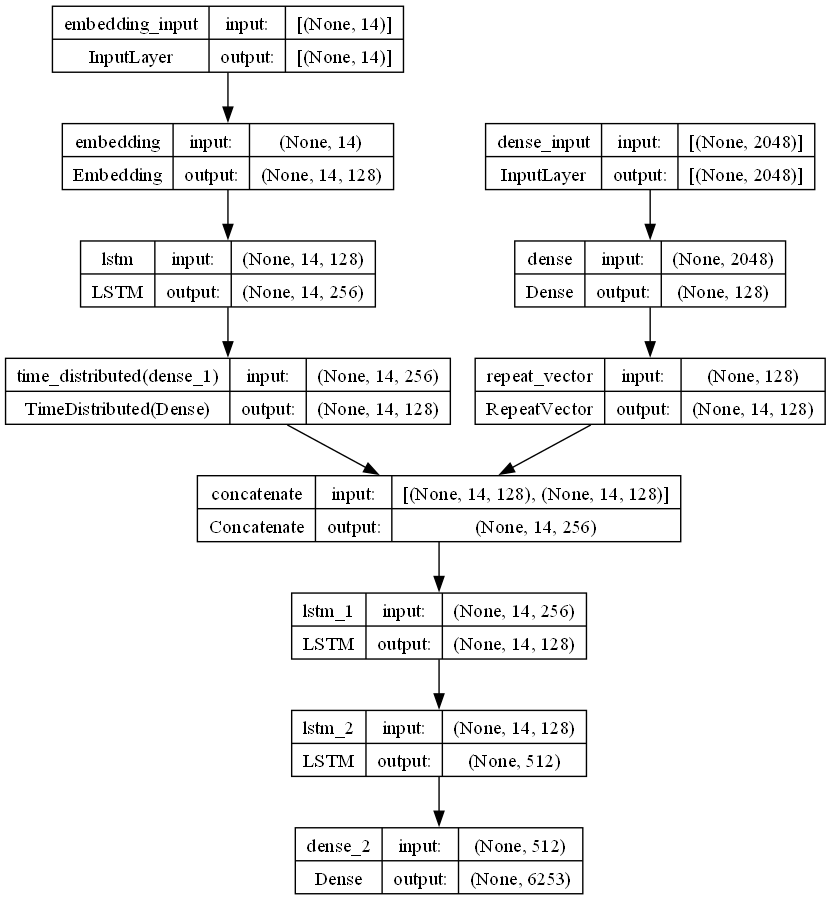

In [28]:
plot_model(final_model,'model1.png',show_shapes=True,dpi=100)

# Model Training

In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# mc = ModelCheckpoint('product_description_generator.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

mc = ModelCheckpoint('product_description_generator1.h5', monitor='accuracy', verbose=1, mode='max', save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='accuracy', patience=10, verbose=1)





In [30]:
def data_generator(img_features, captions_dict, batch_size):
    while True:  # Loop forever so the generator never terminates
        for i in range(0, len(captions_dict), batch_size):
            # Select a batch of keys
            keys = list(captions_dict.keys())[i:i + batch_size]
            
            # Initialize batch arrays
            batch_X, batch_y_in, batch_y_out = [], [], []
            
            # Populate batch arrays
            for key in keys:
                if key in img_features:
                    X, y_in, y_out = generator({key: img_features[key]}, {key: captions_dict[key]})
                    batch_X.extend(X)
                    batch_y_in.extend(y_in)
                    batch_y_out.extend(y_out)
            
            yield ([np.array(batch_X), np.array(batch_y_in)], np.array(batch_y_out))

# Example usage
batch_size = 128  # Adjust based on your system's memory capacity
train_generator = data_generator(img_features, captions_dict, batch_size)

# Model fitting using generator
final_model.fit(train_generator,
                steps_per_epoch=np.ceil(len(captions_dict) / batch_size),
                epochs=200,
                callbacks=[mc, early_stopping])


Epoch 1/200


235/235 [==============================] - ETA: 0s - loss: 4.5828 - accuracy: 0.1788
Epoch 1: accuracy improved from -inf to 0.17876, saving model to product_description_generator1.h5
235/235 [==============================] - 241s 994ms/step - loss: 4.5828 - accuracy: 0.1788
Epoch 2/200
235/235 [==============================] - ETA: 0s - loss: 3.9137 - accuracy: 0.1754
Epoch 2: accuracy did not improve from 0.17876
235/235 [==============================] - 233s 992ms/step - loss: 3.9137 - accuracy: 0.1754
Epoch 3/200
235/235 [==============================] - ETA: 0s - loss: 3.5465 - accuracy: 0.2406
Epoch 3: accuracy improved from 0.17876 to 0.24057, saving model to product_description_generator1.h5
235/235 [==============================] - 234s 997ms/step - loss: 3.5465 - accuracy: 0.2406
Epoch 4/200
235/235 [==============================] - ETA: 0s - loss: 2.6186 - accuracy: 0.4907
Epoch 4: accuracy improved from 0.24057 to 0.49069, saving model to product_descrip

235/235 [==============================] - 230s 980ms/step - loss: 1.0348 - accuracy: 0.7405
Epoch 28/200
235/235 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.7467
Epoch 28: accuracy improved from 0.74048 to 0.74674, saving model to product_description_generator1.h5
235/235 [==============================] - 229s 976ms/step - loss: 0.9984 - accuracy: 0.7467
Epoch 29/200
235/235 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.7536
Epoch 29: accuracy improved from 0.74674 to 0.75364, saving model to product_description_generator1.h5
235/235 [==============================] - 231s 985ms/step - loss: 0.9623 - accuracy: 0.7536
Epoch 30/200
235/235 [==============================] - ETA: 0s - loss: 0.9290 - accuracy: 0.7613
Epoch 30: accuracy improved from 0.75364 to 0.76130, saving model to product_description_generator1.h5
235/235 [==============================] - 230s 979ms/step - loss: 0.9290 - accuracy: 0.7613
Epoch 31/200
235/235 [===

235/235 [==============================] - 253s 1s/step - loss: 0.3163 - accuracy: 0.9179
Epoch 56/200
235/235 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.9233
Epoch 56: accuracy improved from 0.91787 to 0.92327, saving model to product_description_generator1.h5
235/235 [==============================] - 252s 1s/step - loss: 0.3003 - accuracy: 0.9233
Epoch 57/200
235/235 [==============================] - ETA: 0s - loss: 0.2870 - accuracy: 0.9265
Epoch 57: accuracy improved from 0.92327 to 0.92651, saving model to product_description_generator1.h5
235/235 [==============================] - 251s 1s/step - loss: 0.2870 - accuracy: 0.9265
Epoch 58/200
235/235 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9301
Epoch 58: accuracy improved from 0.92651 to 0.93006, saving model to product_description_generator1.h5
235/235 [==============================] - 250s 1s/step - loss: 0.2751 - accuracy: 0.9301
Epoch 59/200
235/235 [===============

235/235 [==============================] - 301s 1s/step - loss: 0.0646 - accuracy: 0.9852
Epoch 115/200
235/235 [==============================] - ETA: 0s - loss: 0.0651 - accuracy: 0.9851
Epoch 115: accuracy did not improve from 0.98518
235/235 [==============================] - 297s 1s/step - loss: 0.0651 - accuracy: 0.9851
Epoch 116/200
235/235 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9860
Epoch 116: accuracy improved from 0.98518 to 0.98601, saving model to product_description_generator1.h5
235/235 [==============================] - 255s 1s/step - loss: 0.0622 - accuracy: 0.9860
Epoch 117/200
235/235 [==============================] - ETA: 0s - loss: 0.0631 - accuracy: 0.9856
Epoch 117: accuracy did not improve from 0.98601
235/235 [==============================] - 254s 1s/step - loss: 0.0631 - accuracy: 0.9856
Epoch 118/200
235/235 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9857
Epoch 118: accuracy did not improve from 0

235/235 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9886
Epoch 146: accuracy did not improve from 0.98957
235/235 [==============================] - 353s 2s/step - loss: 0.0481 - accuracy: 0.9886
Epoch 147/200
235/235 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9890
Epoch 147: accuracy did not improve from 0.98957
235/235 [==============================] - 365s 2s/step - loss: 0.0465 - accuracy: 0.9890
Epoch 148/200
235/235 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9899
Epoch 148: accuracy improved from 0.98957 to 0.98992, saving model to product_description_generator1.h5
235/235 [==============================] - 367s 2s/step - loss: 0.0441 - accuracy: 0.9899
Epoch 149/200
235/235 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9904
Epoch 149: accuracy improved from 0.98992 to 0.99039, saving model to product_description_generator1.h5
235/235 [==============================] -

Epoch 179/200
235/235 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9920
Epoch 179: accuracy improved from 0.99166 to 0.99196, saving model to product_description_generator1.h5
235/235 [==============================] - 308s 1s/step - loss: 0.0353 - accuracy: 0.9920
Epoch 180/200
235/235 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9911
Epoch 180: accuracy did not improve from 0.99196
235/235 [==============================] - 311s 1s/step - loss: 0.0374 - accuracy: 0.9911
Epoch 181/200
235/235 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9908
Epoch 181: accuracy did not improve from 0.99196
235/235 [==============================] - 298s 1s/step - loss: 0.0385 - accuracy: 0.9908
Epoch 182/200
235/235 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9915
Epoch 182: accuracy did not improve from 0.99196
235/235 [==============================] - 292s 1s/step - loss: 0.0361 - accuracy: 

In [31]:
# final_model.fit([X, y_in], y_out,
#                 batch_size=512,
#                 epochs=200,
#                 callbacks=[mc, early_stopping])

In [32]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

# Saving the final trained model and the vocabulary dictionary

In [33]:
final_model.save('product_description_generator1.h5')

In [34]:
np.save('vocab1.npy',count_words)

# Generating sample predictions

1/1 [==============================] - 0s 34ms/step
Caption:  men black dial watch


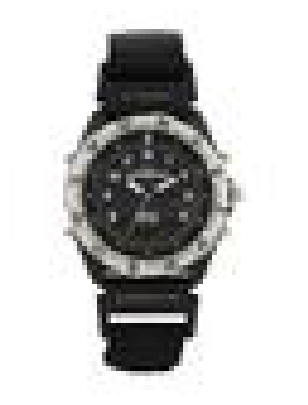

1/1 [==============================] - 0s 34ms/step
Caption:  nike unisex blended red backpacks


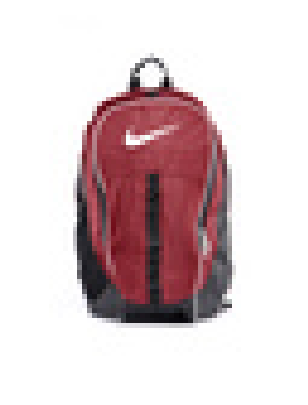

1/1 [==============================] - 0s 34ms/step
Caption:  boys printed yellow t-shirt


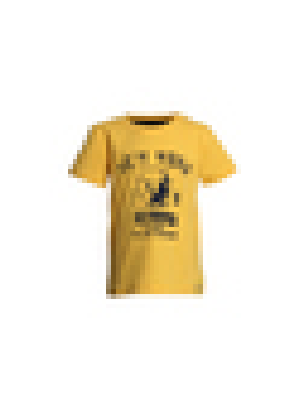

1/1 [==============================] - 0s 33ms/step
Caption:  men white dial watch


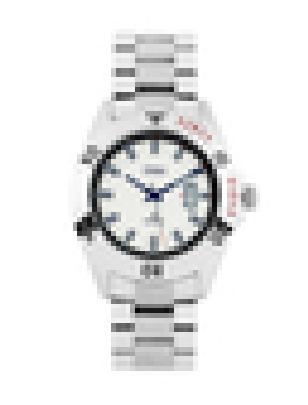

1/1 [==============================] - 0s 31ms/step
Caption:  women beige handbag


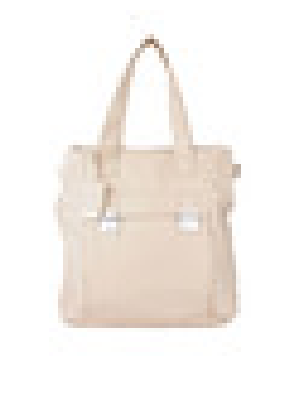

1/1 [==============================] - 0s 36ms/step
Caption:  men casual black casual shoes


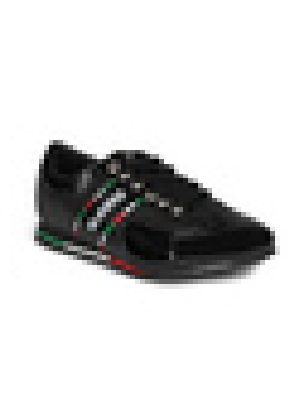

1/1 [==============================] - 0s 37ms/step
Caption:  men bolt fass blue sports shoe


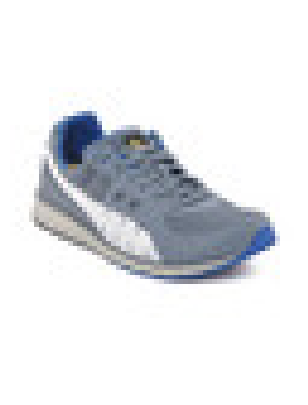

1/1 [==============================] - 0s 33ms/step
Caption:  men light blue thin white shirt


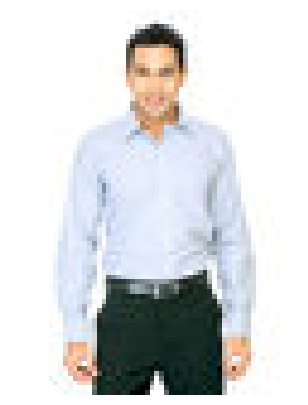

1/1 [==============================] - 0s 40ms/step
Caption:  men derby ii white sports shoes


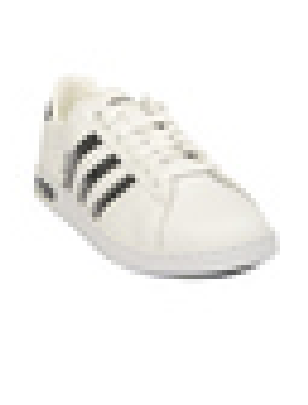

1/1 [==============================] - 0s 36ms/step
Caption:  men grey t-shirt


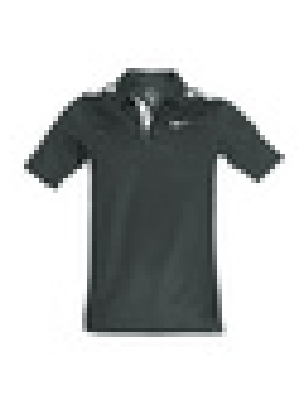

In [35]:
def display_predictions_for_random_images(num_predictions=10):
    for _ in range(num_predictions):
        random_row = df.sample().iloc[0]  # Randomly select a row from the DataFrame
        image_bytes = random_row['image']['bytes']

        # Open the image for feature extraction
        test_img_processed = preprocess_image_from_bytes(image_bytes)  # Preprocessed image ready for feature extraction
        
        # Additionally, open the image for visualization
        test_img = Image.open(BytesIO(image_bytes))  # Open the image for display

        # Extract features
        features = model.predict(test_img_processed).reshape(1, 2048)  # Ensure this matches your feature extraction process

        # Now `features` has the shape expected by `final_model`
        pred_text = ['startofseq']
        caption = ''
        count = 0

        while count < 25:
            count += 1
            encoded = [count_words[word] for word in pred_text if word in count_words]  # Encode current text
            encoded = pad_sequences([encoded], maxlen=MAX_LEN, padding='post', truncating='post')
            pred_idx = np.argmax(final_model.predict([features, encoded]))  # Now using extracted features
            sampled_word = inverse_dict.get(pred_idx, '')  # Use get to avoid KeyError
            if sampled_word == 'endofseq' or sampled_word == '':
                break
            caption += ' ' + sampled_word
            pred_text.append(sampled_word)

        # Visualization part remains the same
        print(f"Caption: {caption}")  # Debugging print statement

        plt.figure(figsize=(5, 5))
        plt.imshow(test_img)  # Now using 'test_img' for display
        plt.xlabel(caption)
        plt.axis('off')
        plt.show()

display_predictions_for_random_images(10)